In [1]:
# Imports
import os
import math
import pandas as pd
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

import IPython
import IPython.display


# Data import and preprocessing

In [2]:
# Read data
print("Reading data ...")
df = pd.read_csv('../Tidsrekker/CBLTCUSD.csv',
                delimiter=',',
                usecols=['DATE','CBLTCUSD'],
                parse_dates=[0]
                )
# Sort out invalid price
df['CBLTCUSD'] = df['CBLTCUSD'][~(df['CBLTCUSD'] == '.' )]
df['CBLTCUSD'] = pd.to_numeric(df['CBLTCUSD'])


df = df.loc[:, ['DATE', 'CBLTCUSD']]
df.sort_values('DATE', inplace=True, ascending=True)
df = df.reset_index(drop=True)

print('Number of rows and columns after removing missing values:', df.shape)
print('The time series starts from: ', df['DATE'].min())
print('The time series ends on: ', df['DATE'].max())

Reading data ...
Number of rows and columns after removing missing values: (1827, 2)
The time series starts from:  2016-09-27 00:00:00
The time series ends on:  2021-09-27 00:00:00


We let 70% of data be training data, 20% validation and 10% for testing.

In [3]:
print("Splitting data ...")
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

Splitting data ...


In [ ]:
# Goal of the model:
#  Predict CBLSDSDUSD at a specified time in the future.
#   Eg. We want to predict how much Global_active_power will be ten minutes from now.
#       We can use all the values from t-1, t-2, t-3, .... t-history_length to predict t+10

def create_ts_files(dataset, 
                    start_index, 
                    end_index, 
                    history_length, 
                    step_size, 
                    target_step, 
                    num_rows_per_file, 
                    data_folder):
    """Creates TS files.
    From https://towardsdatascience.com/3-steps-to-forecast-time-series-lstm-with-tensorflow-keras-ba88c6f05237
    """
    assert step_size > 0
    assert start_index >= 0
    
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    
    time_lags = sorted(range(target_step+1, target_step+history_length+1, step_size), reverse=True)
    col_names = [f'x_lag{i}' for i in time_lags] + ['y']
    start_index = start_index + history_length
    if end_index is None:
        end_index = len(dataset) - target_step
    
    rng = range(start_index, end_index)
    num_rows = len(rng)
    num_files = math.ceil(num_rows/num_rows_per_file)
    
    # for each file.
    print(f'Creating {num_files} files.')
    for i in range(num_files):
        filename = f'{data_folder}/ts_file{i}.pkl'
        
        if i % 10 == 0:
            print(f'{filename}')
            
        # get the start and end indices.
        ind0 = i*num_rows_per_file
        ind1 = min(ind0 + num_rows_per_file, end_index)
        data_list = []
        
        # j in the current timestep. Will need j-n to j-1 for the history. And j + target_step for the target.
        for j in range(ind0, ind1):
            indices = range(j-1, j-history_length-1, -step_size)
            data = dataset[sorted(indices) + [j+target_step]]
            
            # append data to the list.
            data_list.append(data)

        df_ts = pd.DataFrame(data=data_list, columns=col_names)
        df_ts.to_pickle(filename)
            
    return len(col_names)-1


In [ ]:
%%time

global_active_power = train_df['CBLTCUSD'].values

# Scaled to work with Neural networks.
scaler = MinMaxScaler(feature_range=(0, 1))
global_active_power_scaled = scaler.fit_transform(global_active_power.reshape(-1, 1)).reshape(-1, )

history_length = 7*24*60  # The history length in minutes.
step_size = 10  # The sampling rate of the history. Eg. If step_size = 1, then values from every minute will be in the history.
                #                                       If step size = 10 then values every 10 minutes will be in the history.
target_step = 10  # The time step in the future to predict. Eg. If target_step = 0, then predict the next timestep after the end of the history period.
                  #                                             If target_step = 10 then predict 10 timesteps the next timestep (11 minutes after the end of history).

# The csv creation returns the number of rows and number of features. We need these values below.
num_timesteps = create_ts_files(global_active_power_scaled,
                                start_index=0,
                                end_index=None,
                                history_length=history_length,
                                step_size=step_size,
                                target_step=target_step,
                                num_rows_per_file=128*100,
                                data_folder='ts_data')

# I found that the easiest way to do time series with tensorflow is by creating pandas files with the lagged time steps (eg. x{t-1}, x{t-2}...) and 
# the value to predict y = x{t+n}. We tried doing it using TFRecords, but that API is not very intuitive and lacks working examples for time series.
# The resulting file using these parameters is over 17GB. If history_length is increased, or  step_size is decreased, it could get much bigger.
# Hard to fit into laptop memory, so need to use other means to load the data from the hard drive.

In [ ]:
#
# So we can handle loading the data in chunks from the hard drive instead of having to load everything into memory.
# 
# The reason we want to do this is so we can do custom processing on the data that we are feeding into the LSTM.
# LSTM requires a certain shape and it is tricky to get it right.
#
class TimeSeriesLoader:
    def __init__(self, ts_folder, filename_format):
        self.ts_folder = ts_folder
        
        # find the number of files.
        i = 0
        file_found = True
        while file_found:
            filename = self.ts_folder + '/' + filename_format.format(i)
            file_found = os.path.exists(filename)
            if file_found:
                i += 1
                
        self.num_files = i
        self.files_indices = np.arange(self.num_files)
        self.shuffle_chunks()
        
    def num_chunks(self):
        return self.num_files
    
    def get_chunk(self, idx):
        assert (idx >= 0) and (idx < self.num_files)
        
        ind = self.files_indices[idx]
        filename = self.ts_folder + '/' + filename_format.format(ind)
        df_ts = pd.read_pickle(filename)
        num_records = len(df_ts.index)
        
        features = df_ts.drop('y', axis=1).values
        target = df_ts['y'].values
        
        # reshape for input into LSTM. Batch major format.
        features_batchmajor = np.array(features).reshape(num_records, -1, 1)
        return features_batchmajor, target
    
    # this shuffles the order the chunks will be outputted from get_chunk.
    def shuffle_chunks(self):
        np.random.shuffle(self.files_indices)

In [ ]:
ts_folder = 'ts_data'
filename_format = 'ts_file{}.pkl'
tss = TimeSeriesLoader(ts_folder, filename_format)

# Important decision
We don't care about the time really, so let's just cut out all of that..

In [4]:
# Controversial take: Cut out datetime values
train_df = train_df.loc[:,'CBLTCUSD']
val_df = val_df.loc[:,'CBLTCUSD']
test_df = test_df.loc[:,'CBLTCUSD']

# Need to re-feed these into DataFrame so Tensorflow becomes happy
train_df = pd.DataFrame(train_df)
val_df = pd.DataFrame(val_df)
test_df = pd.DataFrame(test_df)

In [5]:
print("Normalizing ...")
keepDateTime = False

if keepDateTime:
    train_df.loc[:,'CBLTCUSD']=(train_df.loc[:,'CBLTCUSD']-train_df.loc[:,'CBLTCUSD'].mean())/train_df.loc[:,'CBLTCUSD'].std()
    val_df.loc[:,'CBLTCUSD']=(val_df.loc[:,'CBLTCUSD']-val_df.loc[:,'CBLTCUSD'].mean())/val_df.loc[:,'CBLTCUSD'].std()
    test_df.loc[:,'CBLTCUSD']=(test_df.loc[:,'CBLTCUSD']-test_df.loc[:,'CBLTCUSD'].mean())/test_df.loc[:,'CBLTCUSD'].std()
else:
    train_df = (train_df-train_df.mean()) / train_df.std()
    val_df = (val_df - val_df.mean()) / val_df.std()
    test_df = ( test_df - test_df.mean()) / test_df.std()

Normalizing ...


In [6]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                train_df, val_df, test_df,
                label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        columns = ['CBLTCUSD'] # Quickfix maybe
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        # {name: i for i, name in enumerate(columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        # print("Features", features, sep='\n')
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
                    
        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels


In [7]:
## Test new class:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['CBLTCUSD'])
w2 = WindowGenerator(input_width=300, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=['CBLTCUSD'])

# Let's split!

In [8]:
# Testevindu
# train_df.head(10)
train_df_test = pd.DataFrame(train_df)
train_df_test['CBLTCUSD']

0      -1.119737
1      -1.120084
2      -1.119564
3      -1.120431
4      -1.119737
          ...   
1273   -0.504803
1274   -0.482606
1275   -0.501161
1276   -0.482432
1277   -0.530989
Name: CBLTCUSD, Length: 1278, dtype: float64

In [9]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])
                           
example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

w1.example = example_inputs, example_labels

All shapes are: (batch, time, features)
Window shape: (3, 48, 1)
Inputs shape: (3, 24, 1)
Labels shape: (3, 1, 1)


In [10]:
w1.example = example_inputs, example_labels

In [11]:
# w1.example = example_inputs, example_labels

def plot(self, model=None, plot_col='CBLTCUSD', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

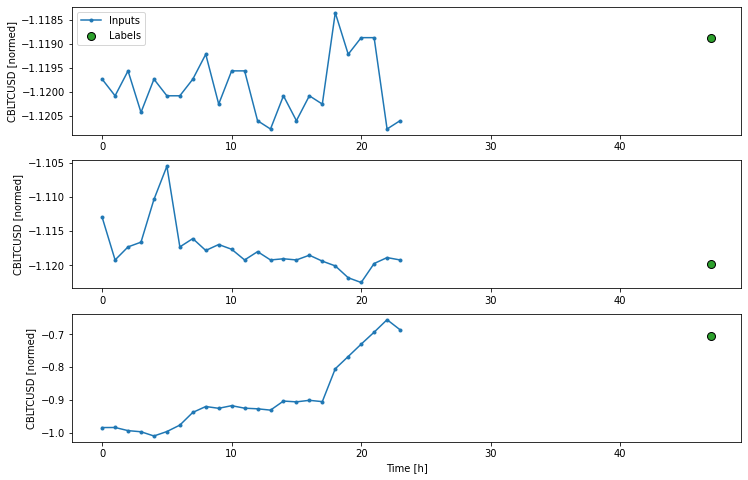

In [12]:
w1.plot()

In [13]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [20]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

# Establishing baseline RNN

In [23]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1, train_df=train_df, val_df=val_df, test_df = test_df, label_columns=['CBLTCUSD'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['CBLTCUSD']

In [ ]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#baseline